In [128]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from tqdm import tqdm
from cdo import *   # python version
cdo = Cdo()
import csv
import cmocean as cmo
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
import math
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator



In [149]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
remap_resolution = '360x180'
mesh_file = 'CORE2_finaltopo_mean.nc'
abg = [0, 0, 0]
variable = 'm_ice'
#input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom/"]
#input_names = ['HIST']
input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/fesom/"]
input_names = ['PICT']
years = range(1990, 2014)

res=[180,180]
figsize=(6,6)
levels = [0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
units = r'$^\circ$C'
columns = 2
dpi = 300
ofile = variable
region = "Global Ocean"

In [150]:
# Obtain input names from path if not set explicitly
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [151]:
# Load fesom2 mesh
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2


In [152]:
# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [153]:
# Load model Data
data = OrderedDict()

def load_parallel(variable,path,remap_resolution,meshpath,mesh_file):
    data1 = cdo.copy(input='-setmissval,nan -setctomiss,0 -remap,r'+remap_resolution+','+meshpath+'/weights_unstr_2_r'+remap_resolution+'.nc -setgrid,'+meshpath+'/'+mesh_file+' '+str(path),returnArray=variable)
    return data1


for exp_path, exp_name  in zip(input_paths, input_names):

    datat = []
    t = []
    temporary = []
    for year in tqdm(years):
        path = exp_path+'/'+variable+'.fesom.'+str(year)+'.nc'
        temporary = dask.delayed(load_parallel)(variable,path,remap_resolution,meshpath,mesh_file)
        t.append(temporary)

    with ProgressBar():
        datat = dask.compute(t)
    data[exp_name] = np.squeeze(datat)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 14569.88it/s]

[                                        ] | 0% Completed |  0.0s

[                                        ] | 0% Completed | 18.5s

IOStream.flush timed out


[                                        ] | 0% Completed | 39.5s

IOStream.flush timed out


[########################################] | 100% Completed | 58.8s


In [154]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [155]:
data_model_mean = OrderedDict()

for exp_name in input_names:
    data_model_mean[exp_name] = data[exp_name]
    if len(np.shape(data_model_mean[exp_name])) > 2:
        data_model_mean[exp_name] = np.nanmean(data_model_mean[exp_name],axis=0)

print(np.shape(data_model_mean[exp_name]))

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
data_model_mean[exp_name], lon = add_cyclic_point(data_model_mean[exp_name], coord=lon)

nrows, ncol = define_rowscol(input_paths)


(12, 180, 360)


/tmp/ipykernel_30371/1380112487.py:6: RuntimeWarning: Mean of empty slice
  data_model_mean[exp_name] = np.nanmean(data_model_mean[exp_name],axis=0)


/tmp/ipykernel_30371/1863044704.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)


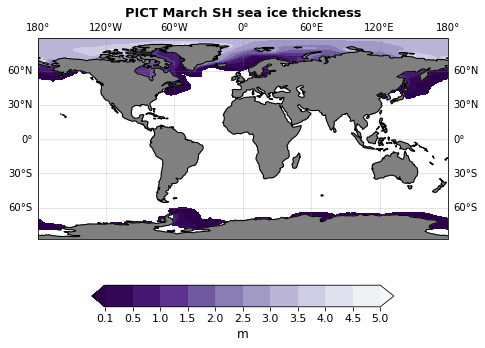

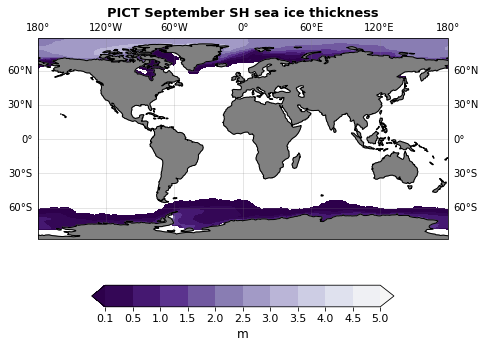

In [156]:
for seas in ['March', 'September']:
    if seas == 'March':
        nseas=2
    elif seas == 'September':
        nseas=8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    i = 0
    for hemi in ['SH']:
        for key in input_names:

            axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
            axes[i].add_feature(cfeature.COASTLINE,zorder=3)

            new_cmap = truncate_colormap(plt.cm.PuOr_r, 0, 0.5)

            imf=plt.contourf(lon, lat, data_model_mean[exp_name][nseas], cmap=new_cmap, 
                             levels=levels, extend='both',
                             transform=ccrs.PlateCarree(),zorder=1)

            axes[i].set_ylabel('K')
            axes[i].set_title(key+ " "+seas+" "+hemi+" sea ice thickness", fontsize=13,fontweight='bold')
            axes[i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='grey'))

            plt.tight_layout() 

            gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color='gray', alpha=0.2, linestyle='-')
            gl.xlabels_bottom = False

            cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
            cbar_ax_abs.tick_params(labelsize=12)
            cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
            cb.set_label(label="m", size='12')
            cb.ax.tick_params(labelsize='11')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)


            i = i+1


        #for label in cb.ax.xaxis.get_ticklabels()[::2]:
        #    label.set_visible(False)

        plt.savefig(key+ "_"+seas+"_"+hemi+"_sea_ice_thickness.png",dpi=300,bbox_inches='tight')


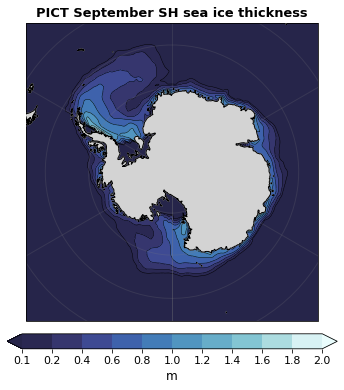

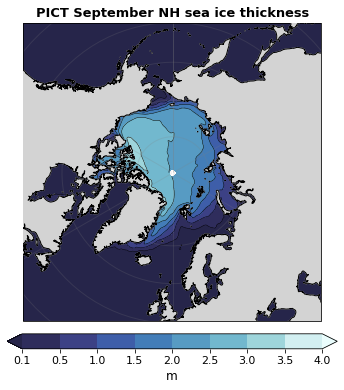

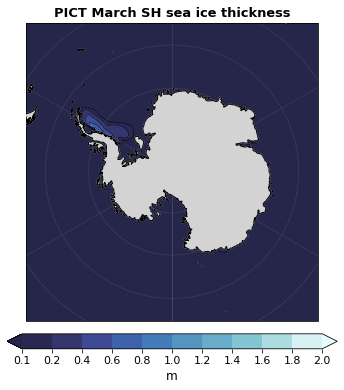

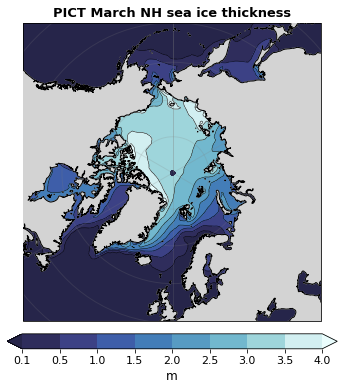

In [161]:

figsize=(6,6)

new_cmap = truncate_colormap(cmo.cm.ice, 0.15, 1)

for seas in ['September','March']:
    if seas == 'March':
        nseas=2
    elif seas == 'September':
        nseas=8
    for hemi in ['SH','NH']:
        for key in input_names:
            data_nonan = np.nan_to_num(data_model_mean[exp_name][nseas],0)

            fig =plt.figure(figsize=(6,6))

            if hemi == 'SH':
                levels=[0.1,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]   
                ax=plt.axes(projection=ccrs.SouthPolarStereo())
                ax.set_extent([-180,180,-55,-90], ccrs.PlateCarree())

            if hemi == 'NH':
                levels=[0.1,0.5,1,1.5,2,2.5,3,3.5,4]
                ax=plt.axes(projection=ccrs.NorthPolarStereo())
                ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
            
            imf=ax.contourf(lon, lat, data_nonan, cmap=new_cmap, 
                             levels=levels, extend='both',
                             transform = ccrs.PlateCarree(),zorder=1)
            lines=ax.contour(lon, lat, data_nonan, 
                             levels=levels, colors='black', linewidths=0.5,
                             transform = ccrs.PlateCarree(),zorder=2)

            ax.set_title(key+ " "+seas+" "+hemi+" sea ice thickness", fontsize=13,fontweight='bold')

            cb = plt.colorbar(imf, orientation='horizontal',ticks=levels, fraction=0.046, pad=0.04)
            cb.set_label(label="m", size='12')
            cb.ax.tick_params(labelsize='11')
            
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgrey'),zorder=3)
            #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',color='black'),zorder=4)
            #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m',color='black'),zorder=4)
            #ax.rivers(resolution='50m', color='black', linewidth=1,zorder=6)

            ax.coastlines(resolution='50m', color='black', linewidth=1,zorder=6)

            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          linewidth=1, color='gray', alpha=0.2, linestyle='-')
            gl.xlabels_bottom = False
            plt.tight_layout() 

            plt.savefig(key+ "_"+seas+"_"+hemi+"_sea_ice_thickness.png",dpi=300,bbox_inches='tight')


In [138]:
# Load GIOMAS
#cmap = cmo.ice
import cmocean as cmo

#levels = np.linspace(0,100,11).astype(int)
#factor=100
new_cmap = truncate_colormap(cmo.cm.ice, 0.15, 1)
extend='both'

# Load model data
import xarray as xr
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

for exp in ['GIOMAS']:
    path ='/p/project/chhb19/streffing1/obs/GIOMAS/GIOMAS_heff_miss_time_mon.nc'
    if exp == 'GIOMAS':
        var = 'heff'
        year_start = 1990
        year_end = 2008
        
# Load model Data
data = OrderedDict()
paths = []

intermediate = []
intermediate = xr.open_mfdataset(path, combine="by_coords", engine="netcdf4", use_cftime=True)
data[var] = intermediate.compute()
data2=data[var].to_array()
x = np.asarray(data[var].lon_scaler).flatten()
y = np.asarray(data[var].lat_scaler).flatten()

In [125]:
#interpolate
lon = np.linspace(0,360,res[0])
lat = np.linspace(-90,90,res[1])
lon2, lat2 = np.meshgrid(lon, lat)


# interpolate data onto regular grid
sit = []
points = np.vstack((x,y)).T
for t in tqdm(range(0, np.shape(data['heff']['heff'])[0])):
    nn_interpolation = NearestNDInterpolator(points, np.nan_to_num(np.asarray(data['heff']['heff'][t,:,:]).flatten(),0))
    sit.append(nn_interpolation((lon2, lat2)))
sit=np.asarray(sit)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.34it/s]


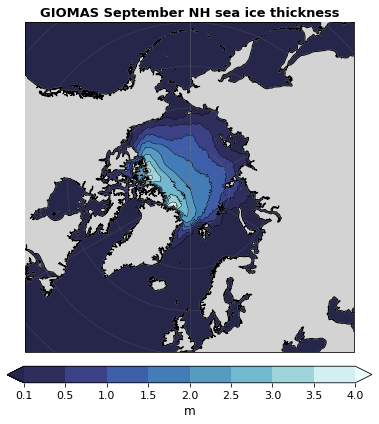

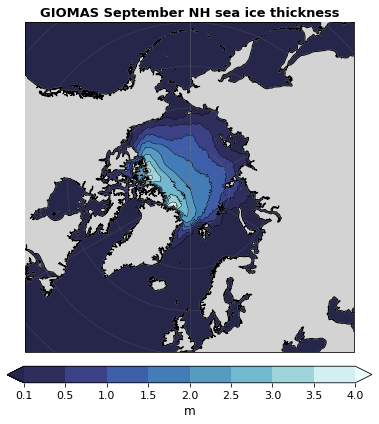

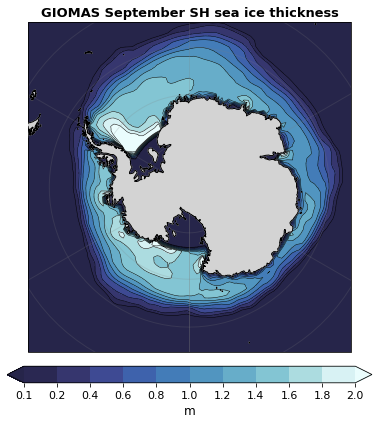

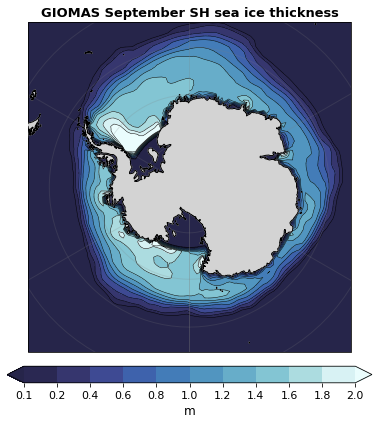

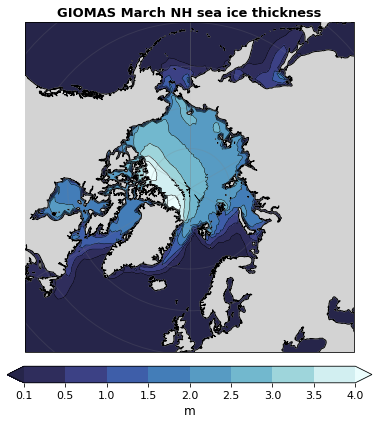

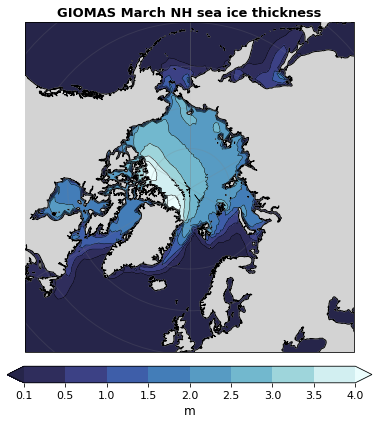

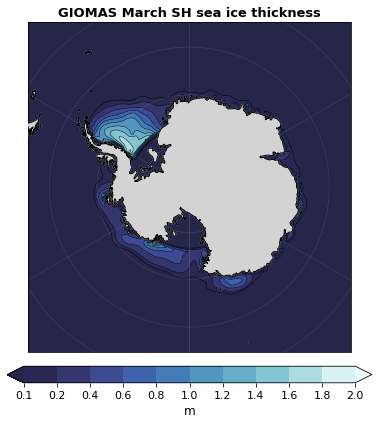

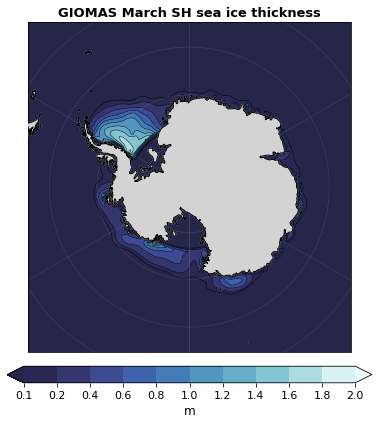

In [139]:

for seas in ['September','March']:
    if seas == 'March':
        nseas=2
    elif seas == 'September':
        nseas=8
    for hemi in ['NH','SH']:
        for key in input_names:
            data_nonan = np.nan_to_num(sit[nseas,:,:],0)
            #data_nonan = sit[nseas,:,:]

            fig =plt.figure(figsize=(6,6))

            if hemi == 'SH':
                levels=[0.1,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2]   
                ax=plt.axes(projection=ccrs.SouthPolarStereo())
                ax.set_extent([-180,180,-55,-90], ccrs.PlateCarree())

            if hemi == 'NH':
                levels=[0.1,0.5,1,1.5,2,2.5,3,3.5,4]
                ax=plt.axes(projection=ccrs.NorthPolarStereo())
                ax.set_extent([-180,180,50,90], ccrs.PlateCarree())
            
            imf=ax.contourf(lon2, lat2, data_nonan, cmap=new_cmap, 
                             levels=levels, extend='both',
                             transform = ccrs.PlateCarree(),zorder=1)
            lines=ax.contour(lon2, lat2, data_nonan, 
                             levels=levels, colors='black', linewidths=0.5,
                             transform = ccrs.PlateCarree(),zorder=2)
            
            ax.set_title("GIOMAS "+seas+" "+hemi+" sea ice thickness", fontsize=13,fontweight='bold')

            cb = plt.colorbar(imf, orientation='horizontal',ticks=levels, fraction=0.046, pad=0.04)
            cb.set_label(label="m", size='12')
            cb.ax.tick_params(labelsize='11')
            
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgrey'),zorder=3)
            #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '50m',color='black'),zorder=4)
            #ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m',color='black'),zorder=4)
            #ax.rivers(resolution='50m', color='black', linewidth=1,zorder=6)

            ax.coastlines(resolution='50m', color='black', linewidth=1,zorder=6)

            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          linewidth=1, color='gray', alpha=0.2, linestyle='-')
            gl.xlabels_bottom = False
            plt.tight_layout() 

            plt.savefig("GIOMAS_"+seas+"_"+hemi+"_sea_ice_thickness.png",dpi=300,bbox_inches='tight')